In [1]:
from scripts.data import fetch_and_save_data
from scripts.eda import main
from scripts.preprocess import FeaturePreprocessor
from scripts.train import train_and_evaluate_model
from sklearn.model_selection import train_test_split
import pandas as pd

1. Correlation Analysis:


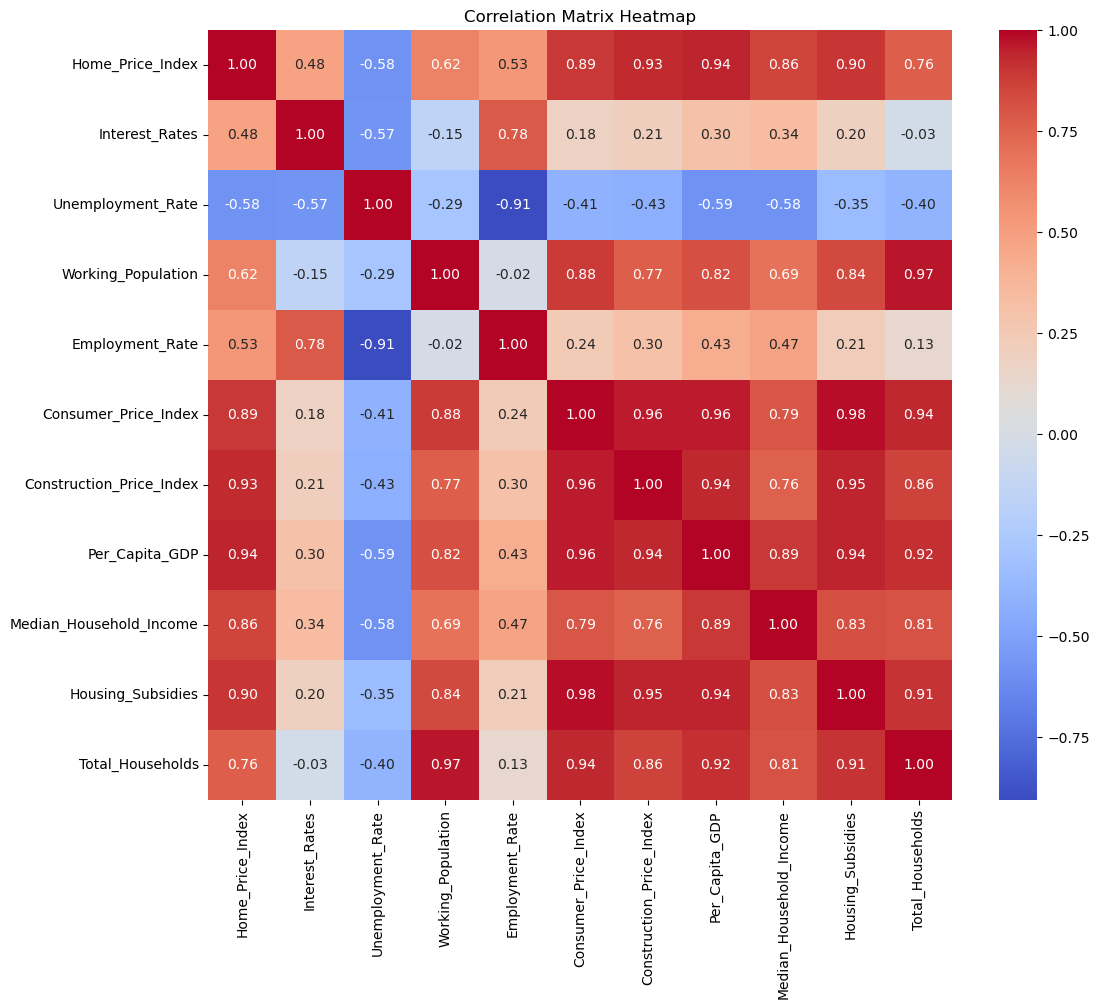


Correlations with Home Price Index:
Home_Price_Index            1.000000
Per_Capita_GDP              0.941680
Construction_Price_Index    0.927942
Housing_Subsidies           0.902745
Consumer_Price_Index        0.890707
Median_Household_Income     0.858392
Total_Households            0.764568
Working_Population          0.624135
Employment_Rate             0.531415
Interest_Rates              0.482845
Unemployment_Rate          -0.584460
Name: Home_Price_Index, dtype: float64

2. Multicollinearity Check:

Variance Inflation Factors:
                   Variable           VIF
2        Working_Population  69775.682403
9          Total_Households  61505.783285
6            Per_Capita_GDP  11679.163629
3           Employment_Rate   8527.835446
4      Consumer_Price_Index   6765.835669
7   Median_Household_Income   2858.266220
8         Housing_Subsidies   1392.203019
5  Construction_Price_Index    618.358223
1         Unemployment_Rate     69.188901
0            Interest_Rates     11.5628

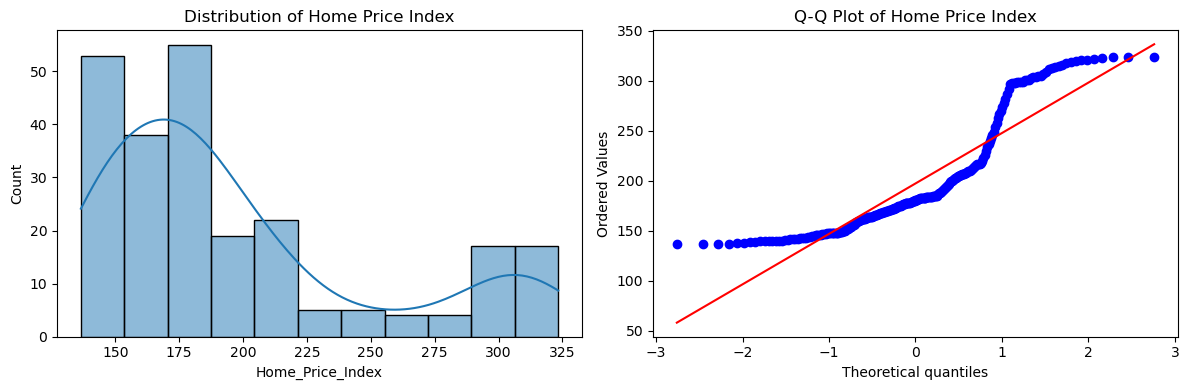

Jarque-Bera statistic: 48.1662
p-value: 0.0000

4. Heteroscedasticity Test Results:


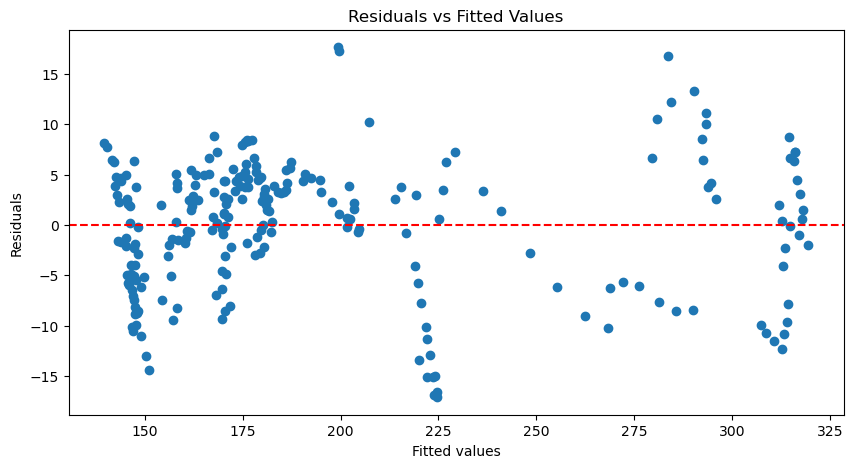

Breusch-Pagan test p-value: 0.0000

5. Checking linearity relationships...


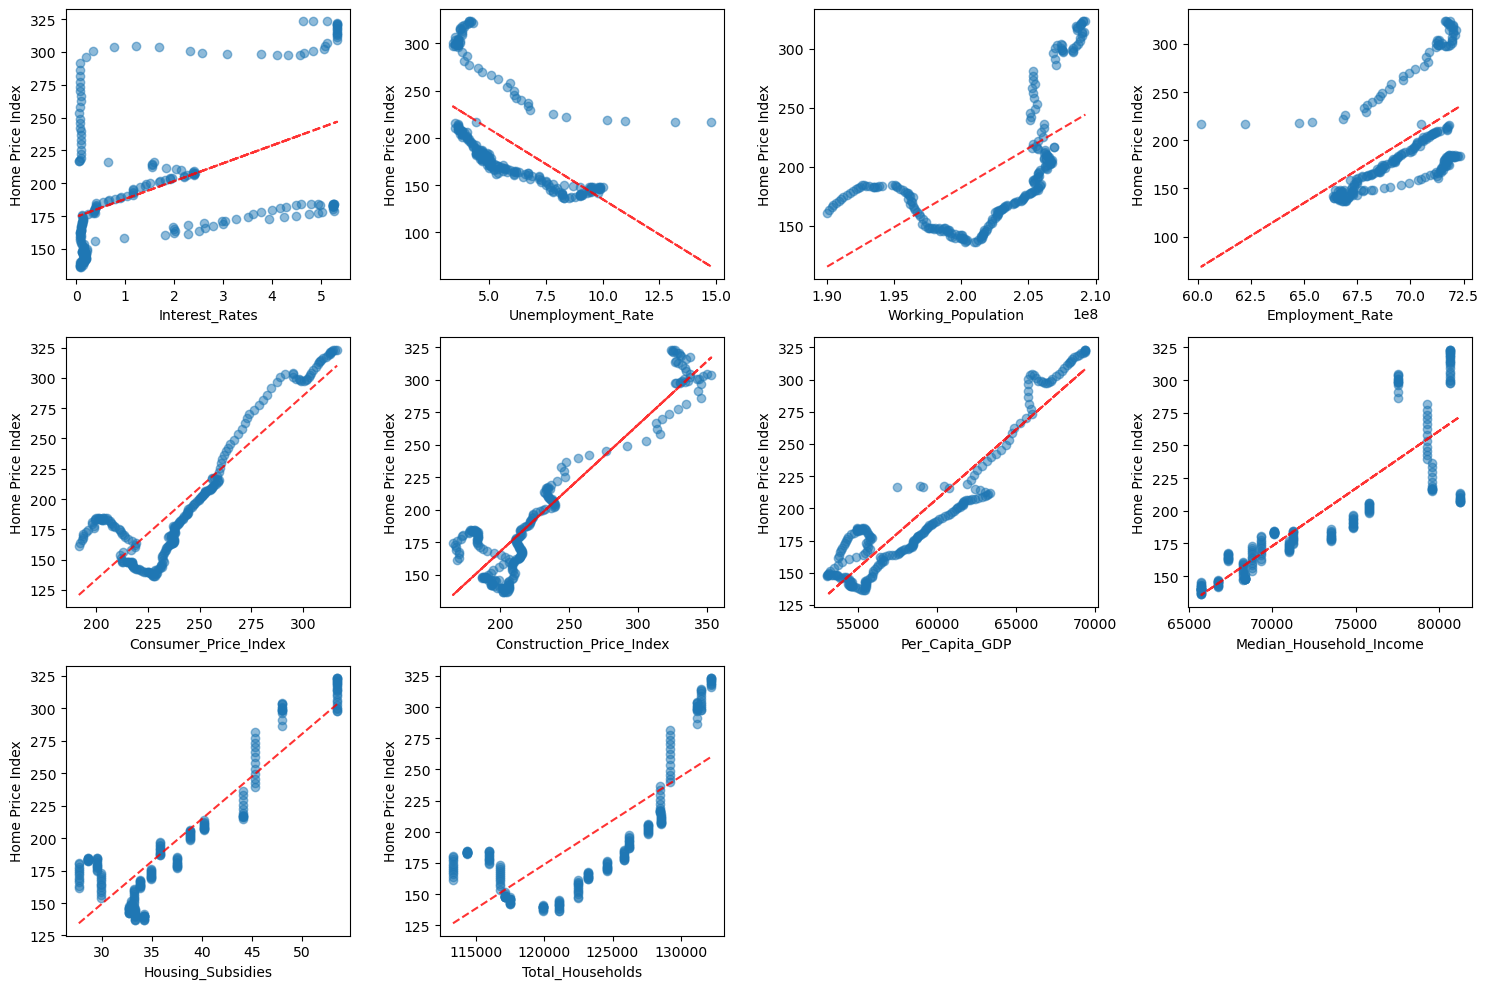

In [2]:
start_date = "2005-01-01"  # Replace with your desired start date
end_date = "2025-12-27"    # Replace with your desired end date

# API URL
base_url = "https://api.stlouisfed.org/fred/series/observations"

# Dictionary to rename columns
feature_dict = {
    "m": {
        "CSUSHPISA": "Home_Price_Index",
        "FEDFUNDS": "Interest_Rates",
        "UNRATE": "Unemployment_Rate",
        "LFWA64TTUSM647S": "Working_Population",
        "LREM64TTUSM156S": "Employment_Rate",
        "CPIAUCSL": "Consumer_Price_Index",
        "WPUSI012011": "Construction_Price_Index"
    },
    "q": {
        "A939RX0Q048SBEA": "Per_Capita_GDP"
    },
    "a": {
        "MEHOINUSA672N": "Median_Household_Income",
        "L312051A027NBEA": "Housing_Subsidies",
        "TTLHH": "Total_Households"
    }
}   

df = fetch_and_save_data(feature_dict, base_url, start_date, end_date)
main()

#  Analysis Results

## 1. Correlation Analysis Results
- **Strong positive correlations** (> 0.7) with *Home Price Index*:
  - *Per_Capita_GDP*: 0.94
  - *Construction_Price_Index*: 0.93
  - *Housing_Subsidies*: 0.90
  - *Consumer_Price_Index*: 0.89
  - *Median_Household_Income*: 0.86
  - *Total_Households*: 0.76

- **Moderate positive correlations**:
  - *Working_Population*: 0.62
  - *Employment_Rate*: 0.53
  - *Interest_Rates*: 0.48

- **Negative correlation**:
  - *Unemployment_Rate*: -0.58

## 2. Multicollinearity Analysis
Severe multicollinearity detected:
- **High VIF values** indicate significant redundancy:
  - *Working_Population*: 69,775.68
  - *Total_Households*: 61,505.78
  - *Per_Capita_GDP*: 11,679.16
  - *Employment_Rate*: 8,527.83
  - *Consumer_Price_Index*: 6,765.83
  - *Median_Household_Income*: 2,858.27

- **Moderate VIF values** for:
  - *Unemployment_Rate*: 69.19
 

- **Low VIF value** for:
  - *Interest_Rates*: 11.56


## 3. Normality Test
- **Jarque-Bera test**:
  - Statistic: ~48.1662, p-value < 0.05
- **Result**: Home Price Index is not normally distributed.

## 4. Heteroscedasticity Test
- **Breusch-Pagan test**:
  - p-value < 0.05
- **Result**: Presence of heteroscedasticity confirmed.
  - Residuals plot shows non-constant variance.

## 5. Linearity Analysis (from scatter plots)
- Non-linear relationships observed with several variables.
- Complex patterns and clusters visible.
- Some variables show distinct segmentation.

---

# Recommended Model:

## Gradient Boosting Models (XGBoost or LightGBM)
**Reasons**:
- Can handle non-linear relationships.
- Robust to multicollinearity.
- No assumption of normality.
- Captures complex patterns.
- Handles heteroscedasticity effectively.

In [3]:
df = pd.read_csv('dataset.csv')
df.set_index('date', inplace=True)
target = 'Home_Price_Index'

# Separate features and target
y = df[target]
X = df.drop(columns=[target])
    
# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.2,  # 80% training, 20% test
    random_state=42  # for reproducibility
)
# Then preprocess using our earlier pipeline
preprocessor = FeaturePreprocessor()
X_processed, y_processed = preprocessor.fit_transform(X_train, y_train)
X_test_processed, y_test_processed = preprocessor.transform(X_test, y_test)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("\nFeatures included:", X_processed.columns.tolist())

Training set shape: (191, 12)
Test set shape: (48, 12)

Features included: ['Interest_Rates', 'Unemployment_Rate', 'Employment_Rate', 'Consumer_Price_Index', 'Construction_Price_Index', 'Per_Capita_GDP', 'Year', 'Per_Capita_GDP_Construction_Price_Index_interaction', 'Housing_Subsidies_Consumer_Price_Index_interaction', 'Interest_Rates_squared', 'Unemployment_Rate_squared', 'Employment_Rate_squared', 'Consumer_Price_Index_squared', 'Construction_Price_Index_squared', 'Per_Capita_GDP_squared', 'Year_squared', 'Per_Capita_GDP_Construction_Price_Index_interaction_squared', 'Housing_Subsidies_Consumer_Price_Index_interaction_squared', 'Median_Household_Income', 'Housing_Subsidies', 'Month']



Performing cross-validation...
Cross-validation R² scores: [0.99543139 0.99703087 0.9985992  0.99211253 0.99815521]
Mean CV R²: 0.9963 (+/- 0.0047)

Training final model...
[0]	validation_0-rmse:0.99064	validation_1-rmse:0.97281
[100]	validation_0-rmse:0.39162	validation_1-rmse:0.39220
[200]	validation_0-rmse:0.16107	validation_1-rmse:0.17040
[300]	validation_0-rmse:0.07464	validation_1-rmse:0.08980


/home/ak265/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/ak265/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[400]	validation_0-rmse:0.04399	validation_1-rmse:0.06288
[500]	validation_0-rmse:0.03271	validation_1-rmse:0.05319
[600]	validation_0-rmse:0.02743	validation_1-rmse:0.04861
[700]	validation_0-rmse:0.02440	validation_1-rmse:0.04622
[800]	validation_0-rmse:0.02173	validation_1-rmse:0.04473
[900]	validation_0-rmse:0.01971	validation_1-rmse:0.04335
[999]	validation_0-rmse:0.01806	validation_1-rmse:0.04239

Evaluating model...

Test Set Metrics:
RMSE: 0.0424
MAE: 0.0291
R2: 0.9980

Generating feature importance plot...


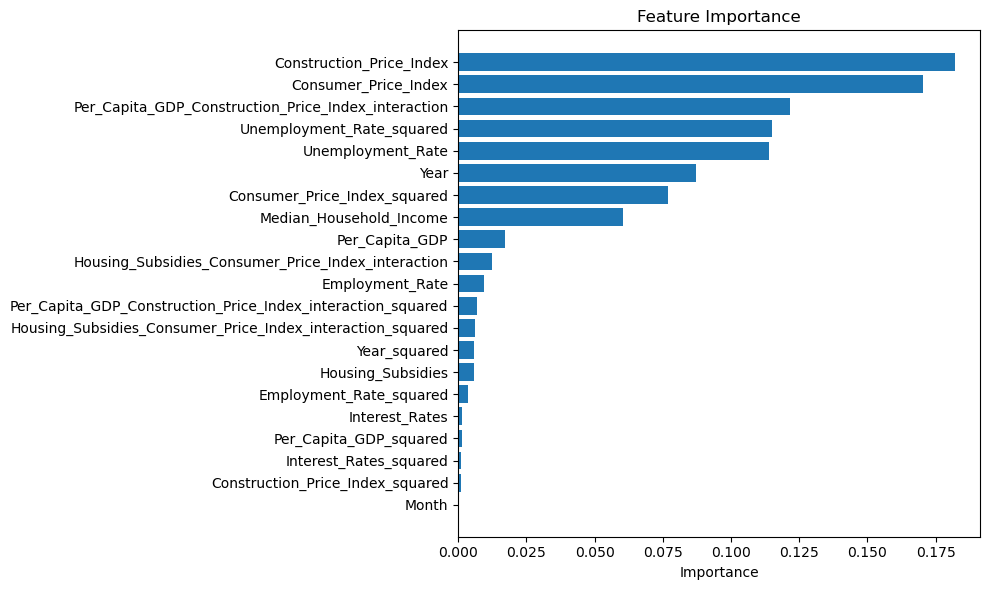


Generating SHAP analysis...


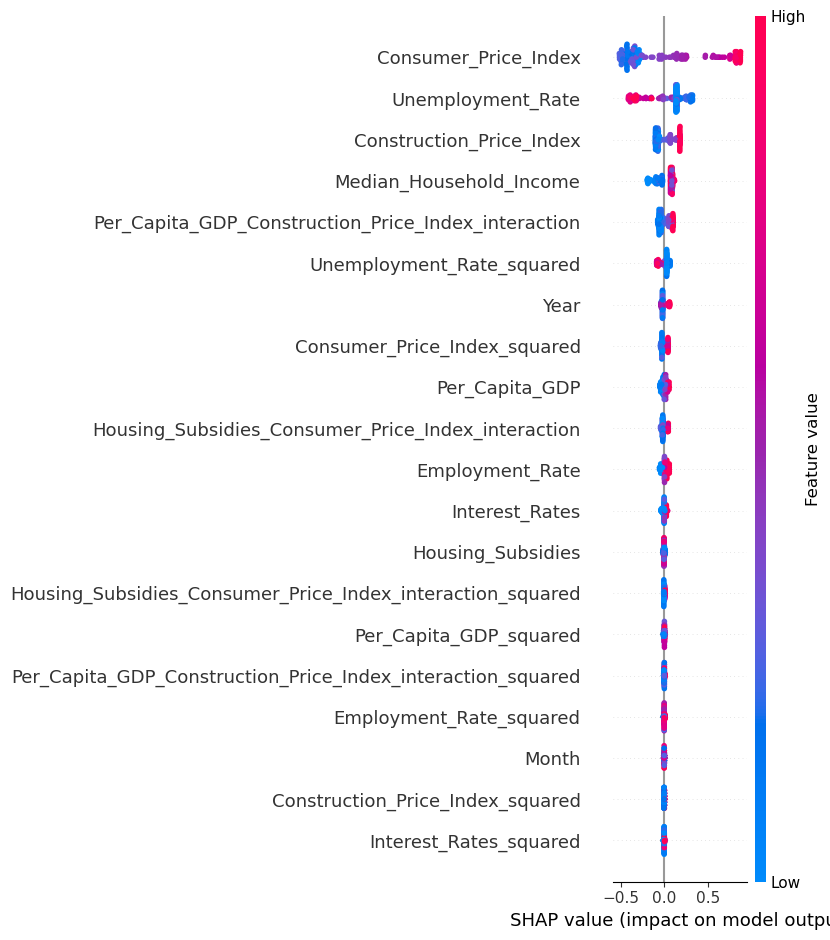

In [4]:
# Train and evaluate the model
trainer, y_pred, metrics, shap_values = train_and_evaluate_model(
    X_processed,
    X_test_processed,
    y_processed,
    y_test_processed,
    X_processed.columns.to_list()
)



Based on the feature importance plot for home prices over the last 20 years, the key insights are:

1. **Key Drivers of Home Prices**:
   - **Construction Price Index**: Dominates in determining home prices, suggesting that rising material and construction costs have directly escalated housing prices.
   - **Consumer Price Index (CPI)**: Strongly correlates with home prices, highlighting how inflation impacts consumer purchasing power and market costs.
   - **Interactions Between Per Capita GDP and Construction Costs**: These underscore the combined influence of economic growth and rising construction costs on housing affordability.

2. **Economic Indicators**:
   - **Per Capita GDP**: Indicates a positive influence, showing that higher national income tends to push up housing demand and prices.
   - **Unemployment Rate and Its Quadratic Terms**: Demonstrates the nuanced relationship—higher unemployment decreases housing affordability, but certain nonlinear impacts might arise, affecting home price trends over time.

3. **Socioeconomic Influences**:
   - **Median Household Income**: Reflects improved affordability for certain demographics, directly contributing to changes in housing market dynamics.
   - **Housing Subsidies and Their Interactions with CPI**: Point to a governmental influence, as subsidies might stabilize prices despite inflationary pressure.

4. **Lesser Impacts**:
   - Factors like **Interest Rates** and their quadratic terms were found to have smaller importance, implying that interest rate changes, while still significant, might play a secondary role compared to broader economic and supply-side drivers.

5. **Temporal Trends**:
   - The inclusion of **Year** and its quadratic terms reflects long-term systemic trends in pricing, influenced by market cycles, policy, and inflation.

---

**Conclusion**:
Over the past 20 years, **construction costs, inflation, and economic growth** were the most influential factors shaping home prices. While government subsidies and income levels alleviated some housing pressures, the systemic impacts of rising construction prices and macroeconomic growth dominated home price trends. This insight emphasizes the need to address construction efficiency and inflation control to ensure housing affordability.